In [1]:
from helpers import create_csv_submission
import numpy as np
import matplotlib.pyplot as plt
from common import sigmoid
from mie import build_k_indices, cross_validation, subsample_class, build_poly
import os
import json

In [2]:
# Parameters
gamma = 0.1
batch_size = 128
num_batches = 20

In [3]:
# Parameters
gamma = 0.0005
batch_size = 64
num_batches = 23


Load data

In [4]:
x_train_norm = np.load("processed/x_train.npy")
x_test_norm = np.load("processed/x_test.npy")
y_train = np.load("processed/y_train.npy")
test_ids = np.load("processed/test_ids.npy")
train_ids = np.load("processed/train_ids.npy")

y_train = (y_train + 1) / 2  # from -1/1 to 0/1

# Add bias term to X (column of 1)
x_train_norm = np.hstack([np.ones((x_train_norm.shape[0], 1)), x_train_norm])
x_test_norm = np.hstack([np.ones((x_test_norm.shape[0], 1)), x_test_norm])

Subsample

In [5]:
x_train_norm, y_train = subsample_class(x_train_norm, y_train, target_ratio=1.0)

Polynomial expansion

In [6]:
X_poly = []

degree = 2

for col in range(x_train_norm.shape[1]):
    phi = build_poly(x_train_norm[:, col], degree)  # shape (N, degree+1)
    X_poly.append(phi[:, 1:])  # saltiamo la colonna di 1 per non duplicare il bias

# Concateno tutte le espansioni colonna per colonna
X_poly = np.concatenate(X_poly, axis=1)

# Aggiungo una colonna di 1 per il bias (una sola volta)
X_poly = np.hstack([np.ones((X_poly.shape[0], 1)), X_poly])


X_test_poly = []

for col in range(x_test_norm.shape[1]):
    phi = build_poly(x_test_norm[:, col], degree)
    X_test_poly.append(phi[:, 1:])  # salta il bias interno

X_test_poly = np.concatenate(X_test_poly, axis=1)
X_test_poly = np.hstack([np.ones((X_test_poly.shape[0], 1)), X_test_poly])

Cross validation

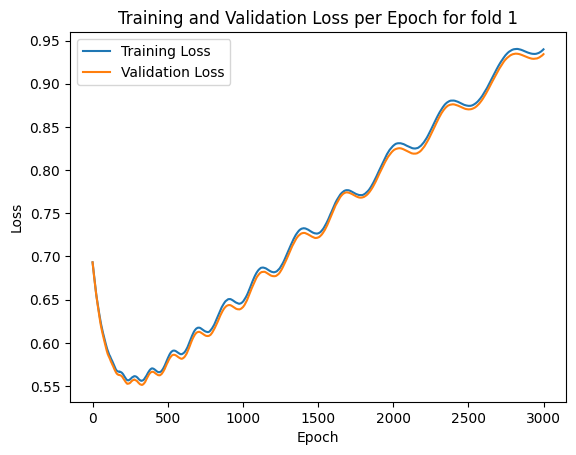

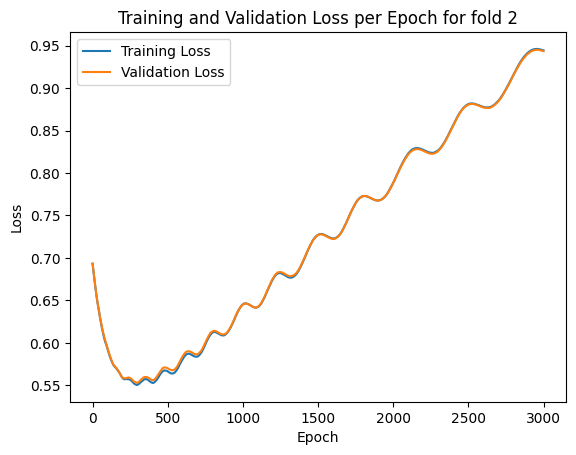


KeyboardInterrupt



In [7]:
k_fold=5
k_indices=build_k_indices(y_train, k_fold, seed=42)

loss_val=[]
loss_tr=[]
ws=[]
initial_w = np.zeros((x_train_norm.shape[1], 1))
initial_m = np.zeros((x_train_norm.shape[1], 1))
initial_v = np.zeros((x_train_norm.shape[1], 1))
b1 = 0.9
b2 = 0.999

for k in range(k_fold):
    w, loss_tr_tmp, loss_val_tmp, x_val, y_val = cross_validation(y_train, x_train_norm, 
                                                                  k_indices, k, initial_w, 
                                                                  initial_m, initial_v, b1, b2, 
                                                                  batch_size=batch_size, num_batches=num_batches,
                                                                  max_iters=3000, gamma=gamma)
    best_val_loss = np.min(loss_val_tmp)
    loss_val.append(best_val_loss)
    ws.append(w)

    plt.plot(loss_tr_tmp, label='Training Loss')
    plt.plot(loss_val_tmp, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss per Epoch for fold {k+1}')
    plt.legend()
    plt.show()
   
w_best=np.mean(ws, axis=0)
gen_err = np.mean(loss_val)

print("Generalization error: ", gen_err)

# === 🔥 Salva automaticamente in tmp/results.json per run.py ===
os.makedirs("tmp", exist_ok=True)

with open("tmp/results.json", "w") as f:
    json.dump({"gen_err": float(gen_err)}, f)

print("✅ gen_err salvato in tmp/results.json")

Test

In [ ]:
y_pred_prob = sigmoid(x_test_norm @ w_best)
y_pred = np.where(y_pred_prob >= 0.5, 1, -1)

create_csv_submission(test_ids, y_pred, 'Train_poly2')